# Kinetics 운동학

In [1]:
# 태클러가 달리는 쿼터백을 멈출 때 충돌 발생
# 쿼터백의 무게 100kg, 속도 5m/s

In [ ]:
# 쿼터백의 운동량 = 질량 * 속도

m = 100.0
v = 5.0

p = m * v
print("쿼터백의 운동량 = ", p)

운동량 =  500.0


In [3]:
# 태클러가 쿼터백을 멈추게 해야 함
# 쿼터백을 멈추게 하려는 힘을 계산

v1 = 0.0  # 멈추게 했을 때
dt = 0.5  # 충돌 시간

dv = v1 - v # 속도 변화량
f = m * dv / dt
print("쿼터백을 멈추게 하는 힘 = ", f)


쿼터백을 멈추게 하는 힘 =  -1000.0


In [4]:
# 따라서 태클러는 1000N의 힘을 0.5 초 동안 가해야 함

# Kinematics 운동학

In [5]:
# 선수가 투사체를 던질 때 최적의 발사각을 찾을 것이다
# 투사체 발사 속도 30m/s
# 지면에서 발사했다고 가정
# 20도에서 50도까지 5도씩 증가시키며 테스트

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
g = 9.81 # m/s^2
v0 = 30.0 # m/s (release speed)
angles = np.arange(20, 55, 5) # [20, 25, 30, ..., 90] 발사각 후보보

In [37]:
def projectile(angle_rad, t, v0):
    x = []
    y = []
    for i in t:
        x_i = v0 * i * np.cos(angle_rad)
        y_i = v0 * i * np.sin(angle_rad) - 0.5 * g * i ** 2
        if y_i < 0:
            break
        x.append(x_i)
        y.append(y_i)
    return x, y

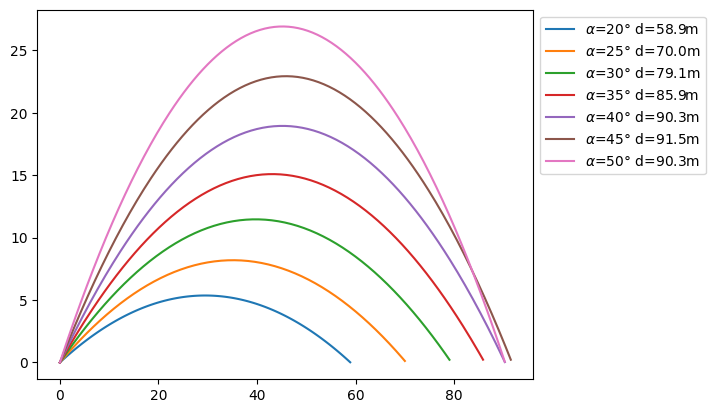

In [38]:
max_distance = 0.0 # 최적의 발사각일 때의 사거리
best_angle = None # 최적의 발사각
t = np.linspace(0, 5 ,300) # 0초부터 5초까지 300개의 시간값 생성
for angle in angles:
    x, y = projectile(np.deg2rad(angle) , t, v0)
    distance = x[-1] # 마지막 x 좌표
    if distance > max_distance:
        max_distance = distance
        best_angle = angle
    plt.plot(x, y, label=r"$\alpha$" + f"={angle}° d={distance:.1f}m")
    plt.legend(bbox_to_anchor=(1,1))
plt.show()    

In [39]:
print(f"최적의 발사각: {best_angle}°, 사거리: {max_distance:.1f}m")

최적의 발사각: 45°, 사거리: 91.5m


In [26]:
# 투사체 사거리 공식을 이용하여 데이터 생성 가능
# 생성된 데이터 셋을 사용하여 모델 학습
# 학습된 모델을 사용하여 투사체의 사거리 예측

In [27]:
from sklearn.model_selection import train_test_split

In [156]:
def generate_data(n_samples):
    v = np.random.uniform(25, 35, n_samples) # 25~35m/s 사이의 랜덤한 발사속도
    alpha = np.random.uniform(20, 60, n_samples) # 20~60도 사이의 랜덤한 발사각
    projectile_range = [np.power(v,2)*np.sin(np.deg2rad(2*alpha)) / g]
    y = np.reshape(projectile_range, (n_samples, 1))

    return train_test_split(np.vstack((v, alpha)).T, y, test_size=0.2, random_state=42)

In [157]:
x_train, x_test, y_train, y_test = generate_data(1000)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [158]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(2, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [159]:
x_train, x_val, x_test = torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_val, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32)
y_train, y_val, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [160]:
train_loader = torch.utils.data.DataLoader(list(zip(x_train, y_train)), batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(list(zip(x_val, y_val)), batch_size=10, shuffle=False)
test_loader = torch.utils.data.DataLoader(list(zip(x_test, y_test)), batch_size=10, shuffle=False)

In [161]:
model = Model()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
num_epochs = 500

In [162]:
train_loss = []
val_loss = []
#train_accuracy = []
#val_accuracy = []

In [163]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.view(-1, 1).float()) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #_, predicted = torch.max(outputs.data, 1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    #epoch_acc = correct / total * 100
    print(f"Train - Loss: {epoch_loss:.4f}")
    train_loss.append(epoch_loss)
    #train_accuracy.append(epoch_acc)


In [164]:
def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.view(-1, 1).float()) 
            running_loss += loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    #epoch_acc = correct / total * 100
    print(f"Val - Loss: {epoch_loss:.4f}")
    val_loss.append(epoch_loss)
    #val_accuracy.append(epoch_acc)

In [165]:
print(model)

Model(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [166]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer)
    evaluate(model, val_loader, criterion)

Epoch 1/500
Train - Loss: 475.2930
Val - Loss: 137.3887
Epoch 2/500
Train - Loss: 137.3130
Val - Loss: 124.6727
Epoch 3/500
Train - Loss: 122.0121
Val - Loss: 110.4810
Epoch 4/500
Train - Loss: 112.7515
Val - Loss: 99.9783
Epoch 5/500
Train - Loss: 101.4097
Val - Loss: 101.1111
Epoch 6/500
Train - Loss: 96.7764
Val - Loss: 88.0490
Epoch 7/500
Train - Loss: 91.1000
Val - Loss: 89.3858
Epoch 8/500
Train - Loss: 84.6986
Val - Loss: 84.5160
Epoch 9/500
Train - Loss: 85.3818
Val - Loss: 101.9641
Epoch 10/500
Train - Loss: 85.5335
Val - Loss: 84.0054
Epoch 11/500
Train - Loss: 83.2207
Val - Loss: 89.5874
Epoch 12/500
Train - Loss: 83.3523
Val - Loss: 80.5999
Epoch 13/500
Train - Loss: 81.7325
Val - Loss: 80.9966
Epoch 14/500
Train - Loss: 81.3538
Val - Loss: 82.1927
Epoch 15/500
Train - Loss: 80.3449
Val - Loss: 115.2338
Epoch 16/500
Train - Loss: 79.7763
Val - Loss: 88.8387
Epoch 17/500
Train - Loss: 79.9709
Val - Loss: 79.8984
Epoch 18/500
Train - Loss: 78.9856
Val - Loss: 78.9149
Epoch 19

In [167]:
model(torch.tensor([[30, 45]], dtype=torch.float32).to(device))

tensor([[91.0500]], grad_fn=<AddmmBackward0>)

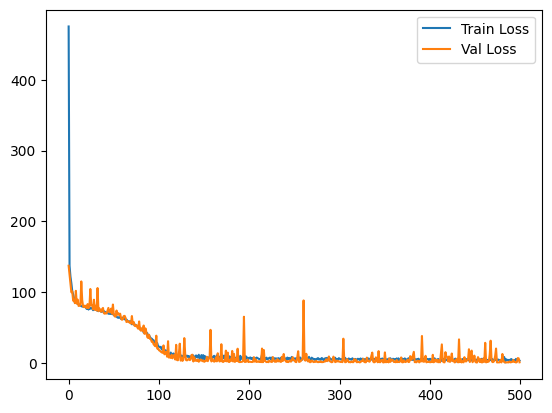

In [168]:
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.show()

# OpenAI gym

AttributeError: module 'numpy' has no attribute 'bool8'

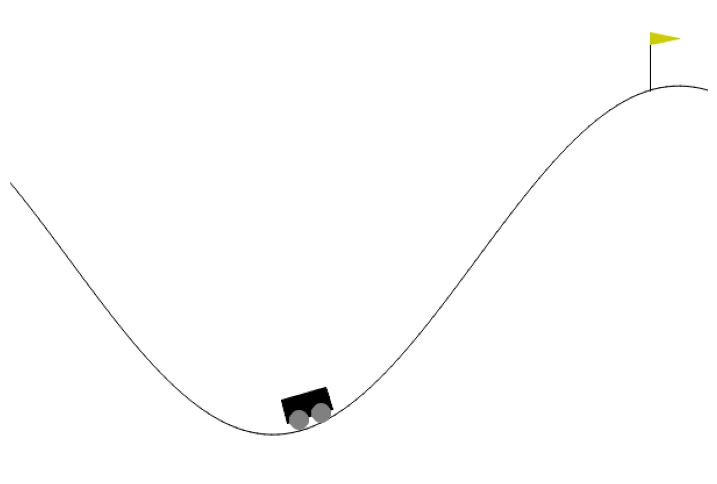

In [187]:
import gym
import matplotlib.pyplot as plt

env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")

# 환경 초기화
state = env.reset()

# 플롯 생성
plt.figure(figsize=(9, 9))
img = plt.imshow(env.render())  # 초기 프레임 설정
plt.axis('off')

# 20 프레임 동안 애니메이션 실행
for _ in range(20):
    action = env.action_space.sample()  # 랜덤 액션 선택
    env.step(action)  # 환경에 적용

    img.set_data(env.render())  # 새로운 프레임 업데이트
    display.display(plt.gcf())
    display.clear_output(wait=True)

# 환경 종료
env.close()
